In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sounddevice as sd

from scipy import signal
from scipy.io import wavfile

### Загрузка звука

In [2]:
filename = 'The Diva Dance.wav'


sample_rate, sound = wavfile.read(filename)
print('Sampling Rate:', sample_rate)
print('Audio Shape:', np.shape(sound))

duration = len(sound) / sample_rate
time = np.arange(0, duration, 1 / sample_rate)  # time vector
time = time[:len(time)]

print(
    f"длительность {duration} \n временная шкала {time} \n размерность времени {len(time)}")

canal1 = sound[:, 0]
canal2 = sound[:, 1]

Sampling Rate: 44100
Audio Shape: (4108032, 2)
длительность 93.15265306122448 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 9.31525850e+01
 9.31526077e+01 9.31526304e+01] 
 размерность времени 4108032


### Визуализация

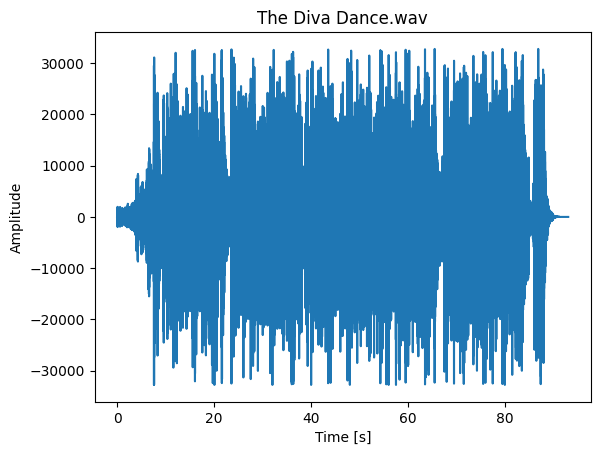

In [3]:
plt.plot(time, canal1)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title(filename)
plt.show()

In [4]:
def make_spectrogram(sound: np.ndarray, sample_rate: int, title: str) -> None:
    adata = sound[:, 0]
    fr, tm, spgram = signal.spectrogram(adata, sample_rate)
    lspg = np.log(spgram)
    plt.pcolormesh(tm, fr, lspg, shading='auto')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title(title)
    plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_61028\862964274.py:4: RuntimeWarning: divide by zero encountered in log
  lspg = np.log(spgram)


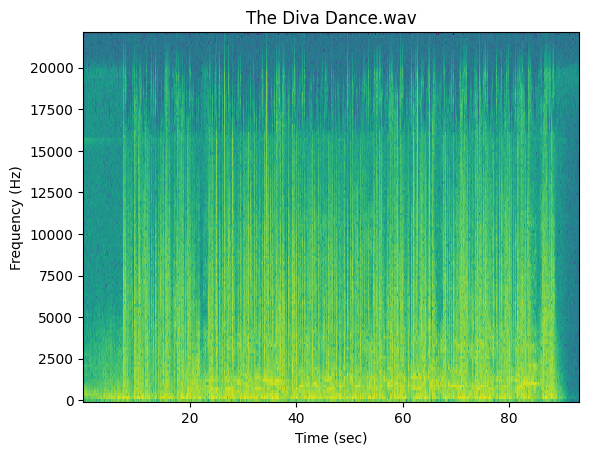

In [5]:
make_spectrogram(sound, sample_rate, filename)

In [6]:
from scipy.fft import rfft, rfftfreq, irfft


def get_fft_and_visualize(data: np.ndarray, sample_rate: int,
                          title: str, log_scale: bool = False) -> None:
    rN = len(data)
    ryf = rfft(data[:, 0])
    rxf = rfftfreq(rN, 1 / sample_rate)

    plt.plot(rxf, np.abs(ryf))
    if log_scale:
        plt.yscale('log')
    plt.xlabel('Частота')
    plt.ylabel('Мощность')
    plt.title(title)
    plt.show()

    return rxf, ryf

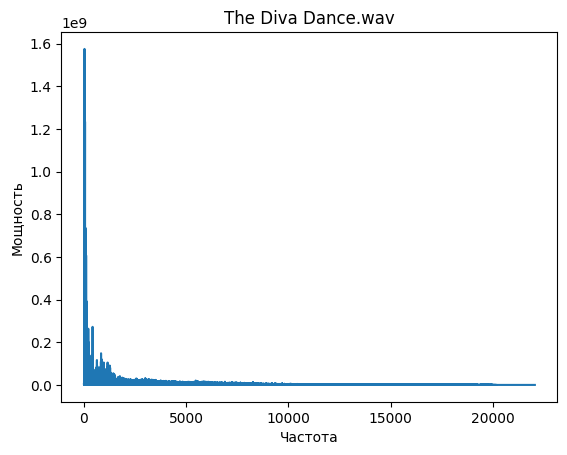

In [7]:
rxf, ryf = get_fft_and_visualize(sound, sample_rate, filename, False)

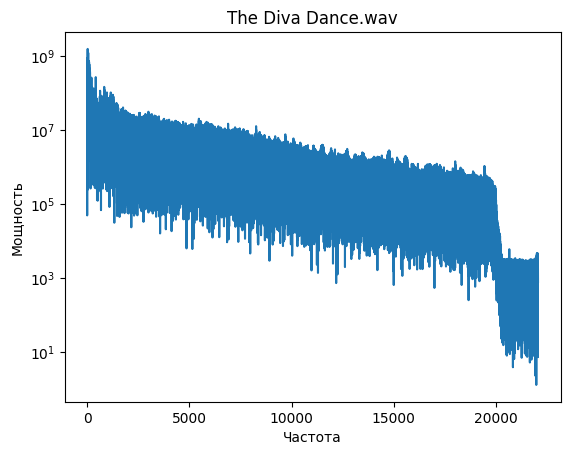

In [8]:
rxf, ryf = get_fft_and_visualize(sound, sample_rate, filename, True)

In [9]:
points_per_freq = len(rxf) / (max(rxf))

target_idx_hf = int(points_per_freq * 900)
target_idx_lf = int(points_per_freq * 300)

yf_hf = ryf.copy()
yf_lf = ryf.copy()
yf_bp = ryf.copy()
yf_zf = ryf.copy()

yf_hf[:target_idx_hf] = 0

yf_lf[target_idx_lf:] = 0

yf_bp[:target_idx_lf] = 0
yf_bp[target_idx_hf:] = 0

yf_zf[target_idx_lf:target_idx_hf] = 0

### Фильтрация Фурье для НЧ, ВЧ фильтров, полосовой фильтр, полосо-заградительный фильтр

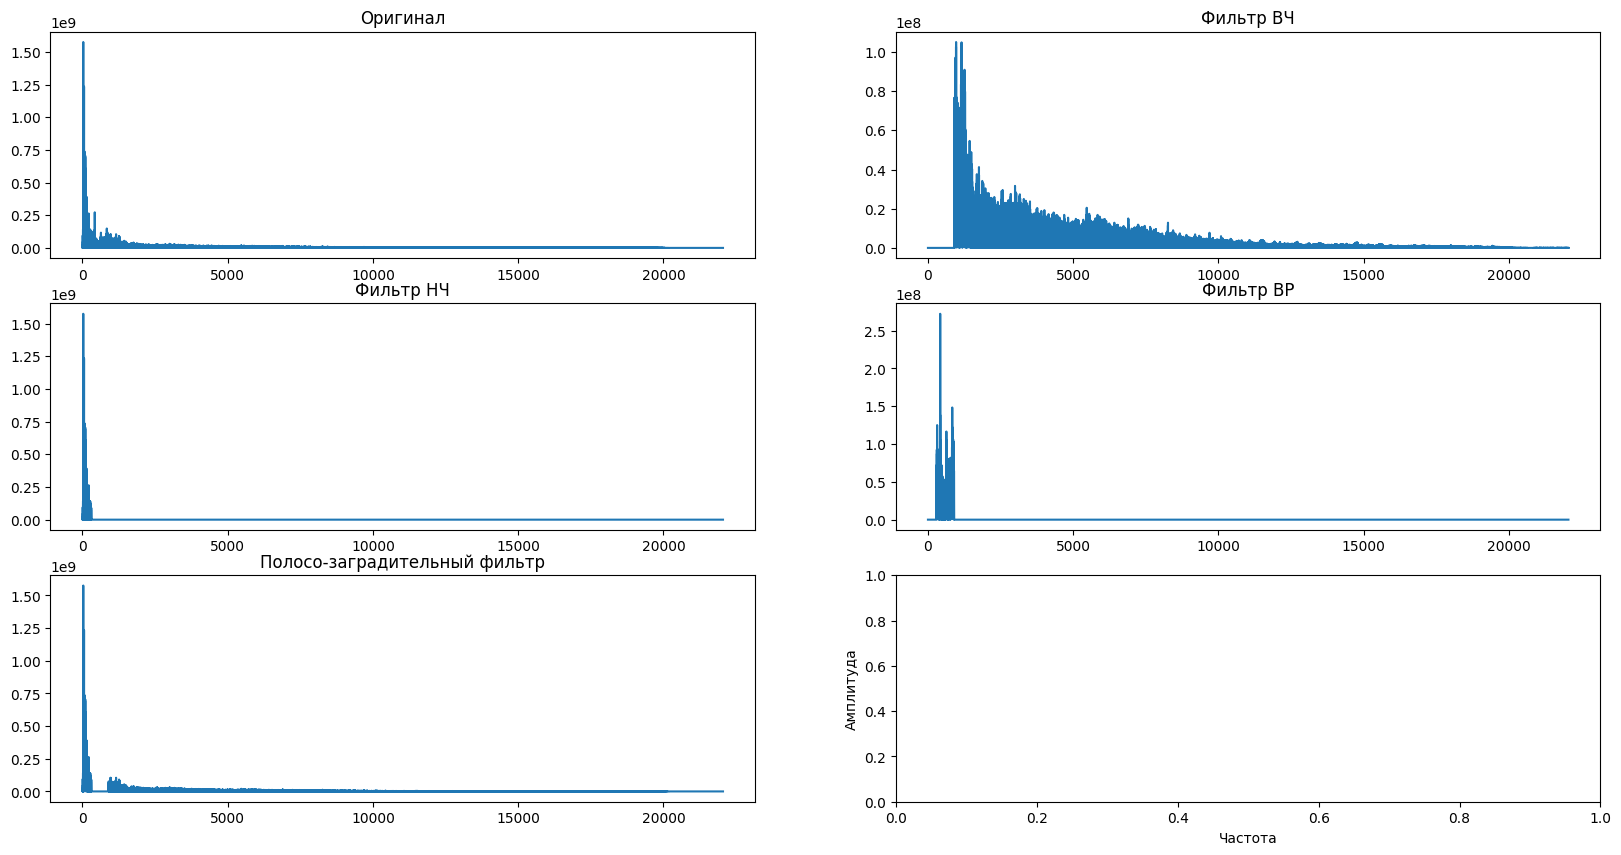

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

ax[0, 0].plot(rxf, np.abs(ryf))
ax[0, 0].set_title("Оригинал")

ax[0, 1].plot(rxf, np.abs(yf_hf))
ax[0, 1].set_title("Фильтр ВЧ")

ax[1, 0].plot(rxf, np.abs(yf_lf))
ax[1, 0].set_title("Фильтр НЧ")

ax[1, 1].plot(rxf, np.abs(yf_bp))
ax[1, 1].set_title("Фильтр BP")

ax[2, 0].plot(rxf, np.abs(yf_zf))
ax[2, 0].set_title("Полосо-заградительный фильтр")

plt.xlabel('Частота')
plt.ylabel('Амплитуда')

plt.show()

In [11]:
new_sig_hf = irfft(yf_hf)
new_sig_lf = irfft(yf_lf)
new_sig_bp = irfft(yf_bp)
new_sig_zf = irfft(yf_zf)

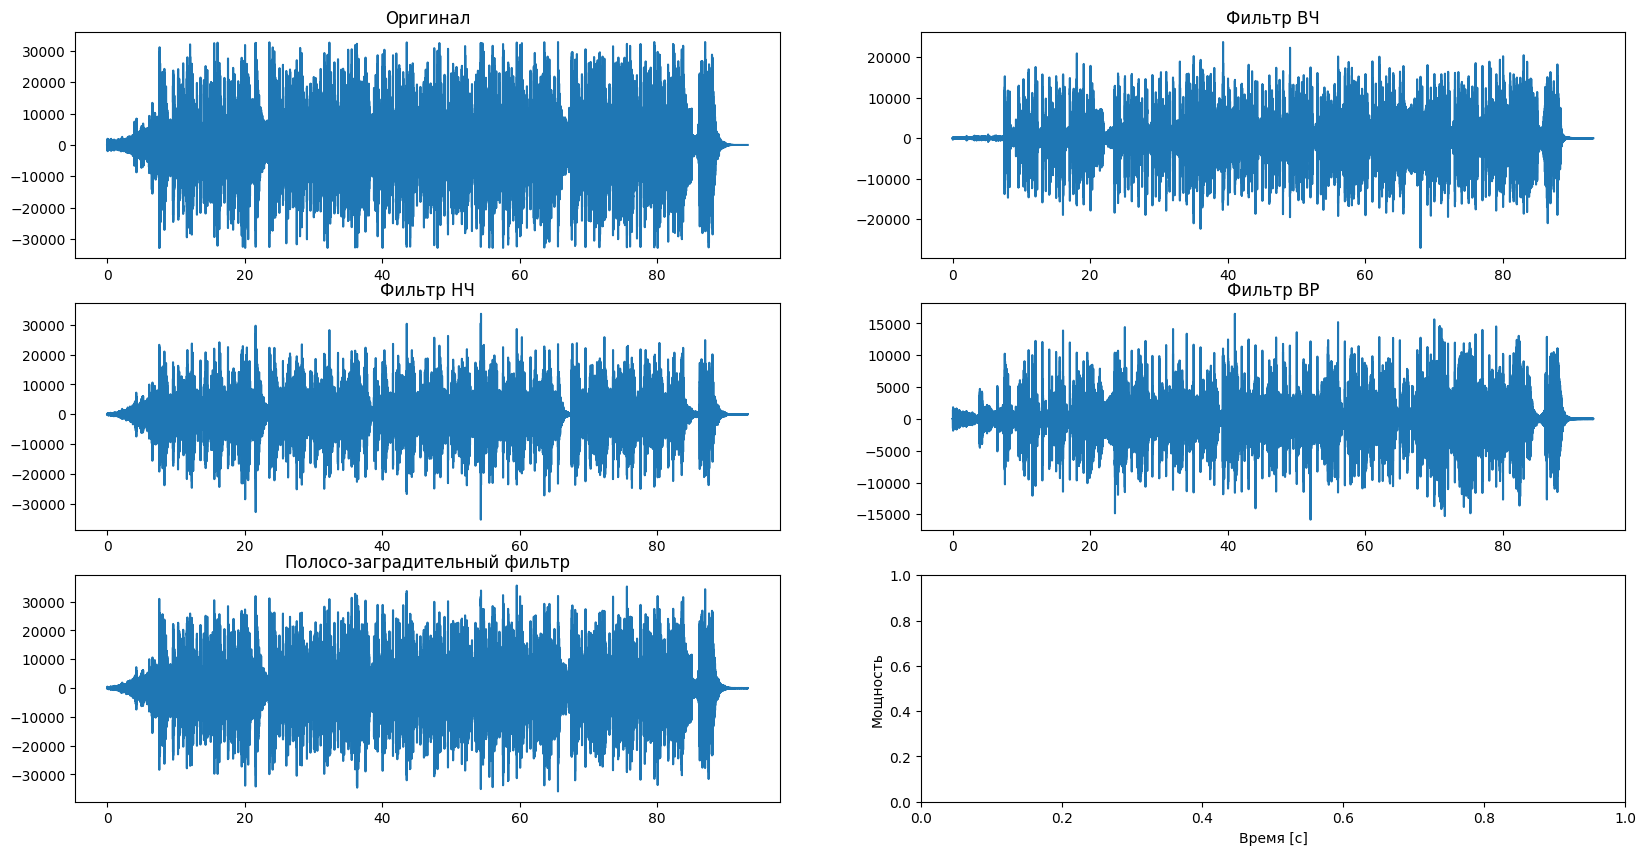

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))

ax[0, 0].plot(time, canal1)
ax[0, 0].set_title("Оригинал")

ax[0, 1].plot(time, new_sig_hf)
ax[0, 1].set_title("Фильтр ВЧ")

ax[1, 0].plot(time, new_sig_lf)
ax[1, 0].set_title("Фильтр НЧ")

ax[1, 1].plot(time, new_sig_bp)
ax[1, 1].set_title("Фильтр BP")

ax[2, 0].plot(time, new_sig_zf)
ax[2, 0].set_title("Полосо-заградительный фильтр")

plt.xlabel('Время [c]')
plt.ylabel('Мощность')

plt.show()

In [13]:
def play_audio(noise: np.ndarray, freq: float) -> None:
    sd.play(noise / np.max(np.abs(noise)), freq)
    sd.wait()


# play_audio(new_sig_hf, sample_rate)
# play_audio(new_sig_lf, sample_rate)  # Звучит забавно
# play_audio(new_sig_bp, sample_rate)
# play_audio(new_sig_zf, sample_rate)

In [ ]:
signal_part = canal1[20000:25000]
time_part = time[20000:25000]

series = pd.Series([time_part, signal_part])

### Экспоненциальное сглаживание

In [14]:
def exponential_smoothing(values, alpha):
    result = [values[0], values[1]]
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n - 1])
    return result

In [55]:
def plot_exponential_smoothing(series, alphas):
    with plt.style.context("seaborn-v0_8-white"):

        plt.figure(figsize=(20, 7))

        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            plt.plot(
                exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha)
            )

        plt.legend(loc="best")
        # plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

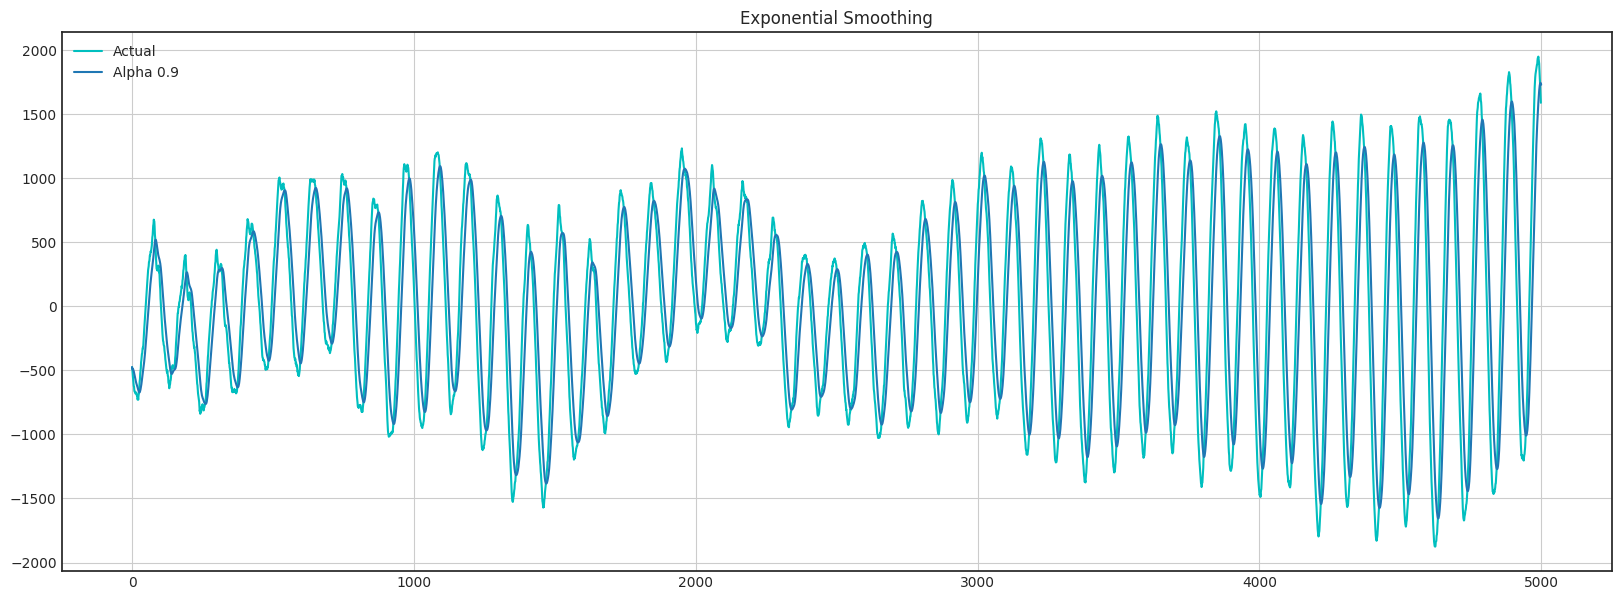

In [56]:
plot_exponential_smoothing(series, alphas=[0.9])

### Двойное экспоненциальное сглаживание

In [53]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


def plot_double_exponential_smoothing(series, alphas, betas):
    with plt.style.context('seaborn-v0_8-white'):
        plt.figure(figsize=(20, 7))
        plt.plot(series[1], "c", label="Actual")

        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series[1], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.legend(loc="best")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

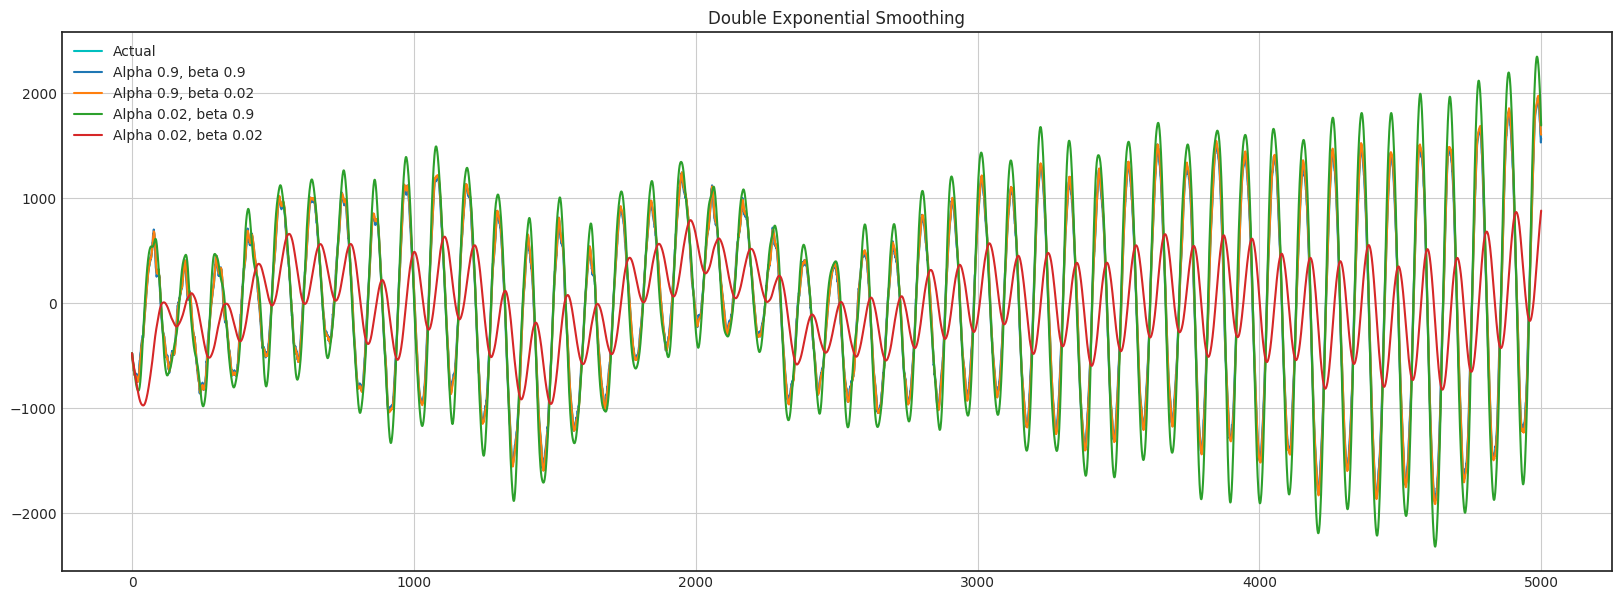

In [54]:
plot_double_exponential_smoothing(series, [0.9, 0.02],  [0.9, 0.02])

### Тройное экспоненциальное сглаживание

In [58]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i + slen] - series[i]) / slen
    return sum / slen


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)

    for j in range(n_seasons):
        season_averages.append(
            sum(series[slen * j:slen * j + slen]) / float(slen))

    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series) + n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m * trend) + seasonals[i % slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * \
                (val - seasonals[i % slen]) + (1 - alpha) * (smooth + trend)
            trend = beta * (smooth - last_smooth) + (1 - beta) * trend
            seasonals[i % slen] = gamma * \
                (val - smooth) + (1 - gamma) * seasonals[i % slen]
            result.append(smooth + trend + seasonals[i % slen])
    return result

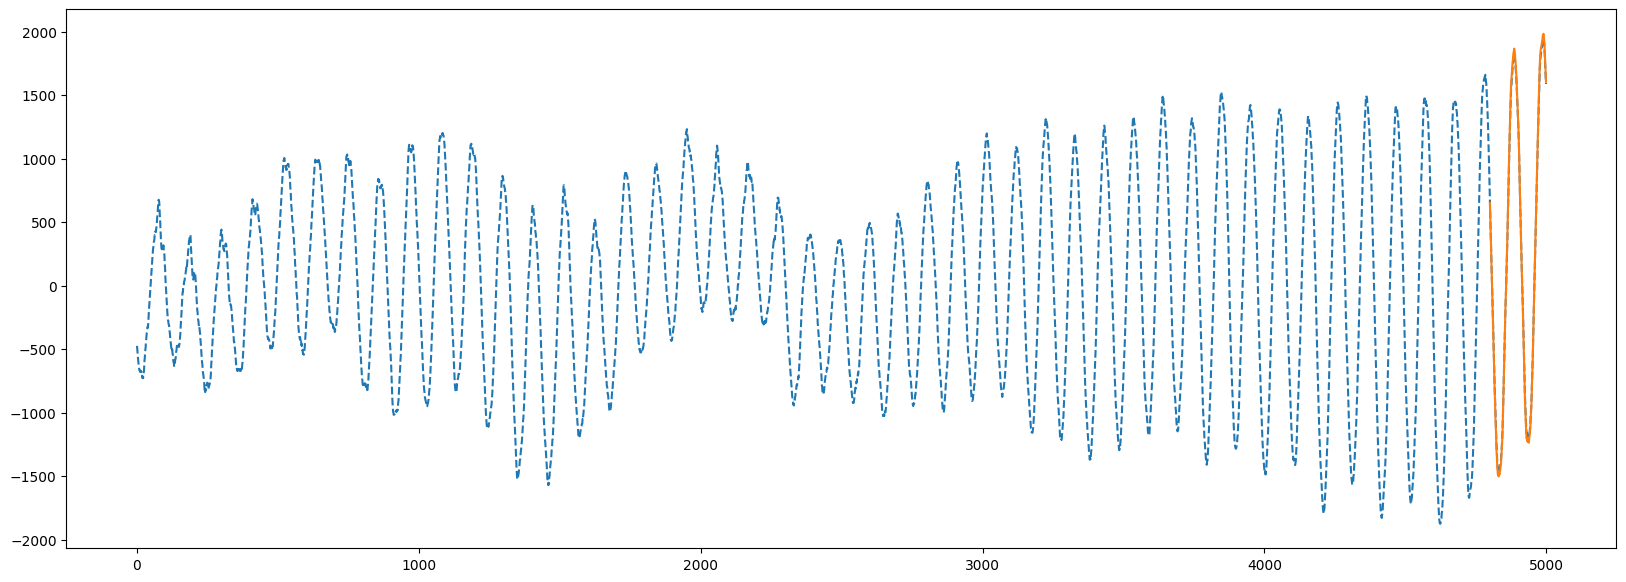

In [70]:
plt.figure(figsize=(20, 7))

count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x, чтобы посмотреть
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])
plt.show()

### Фильтры Чебышева

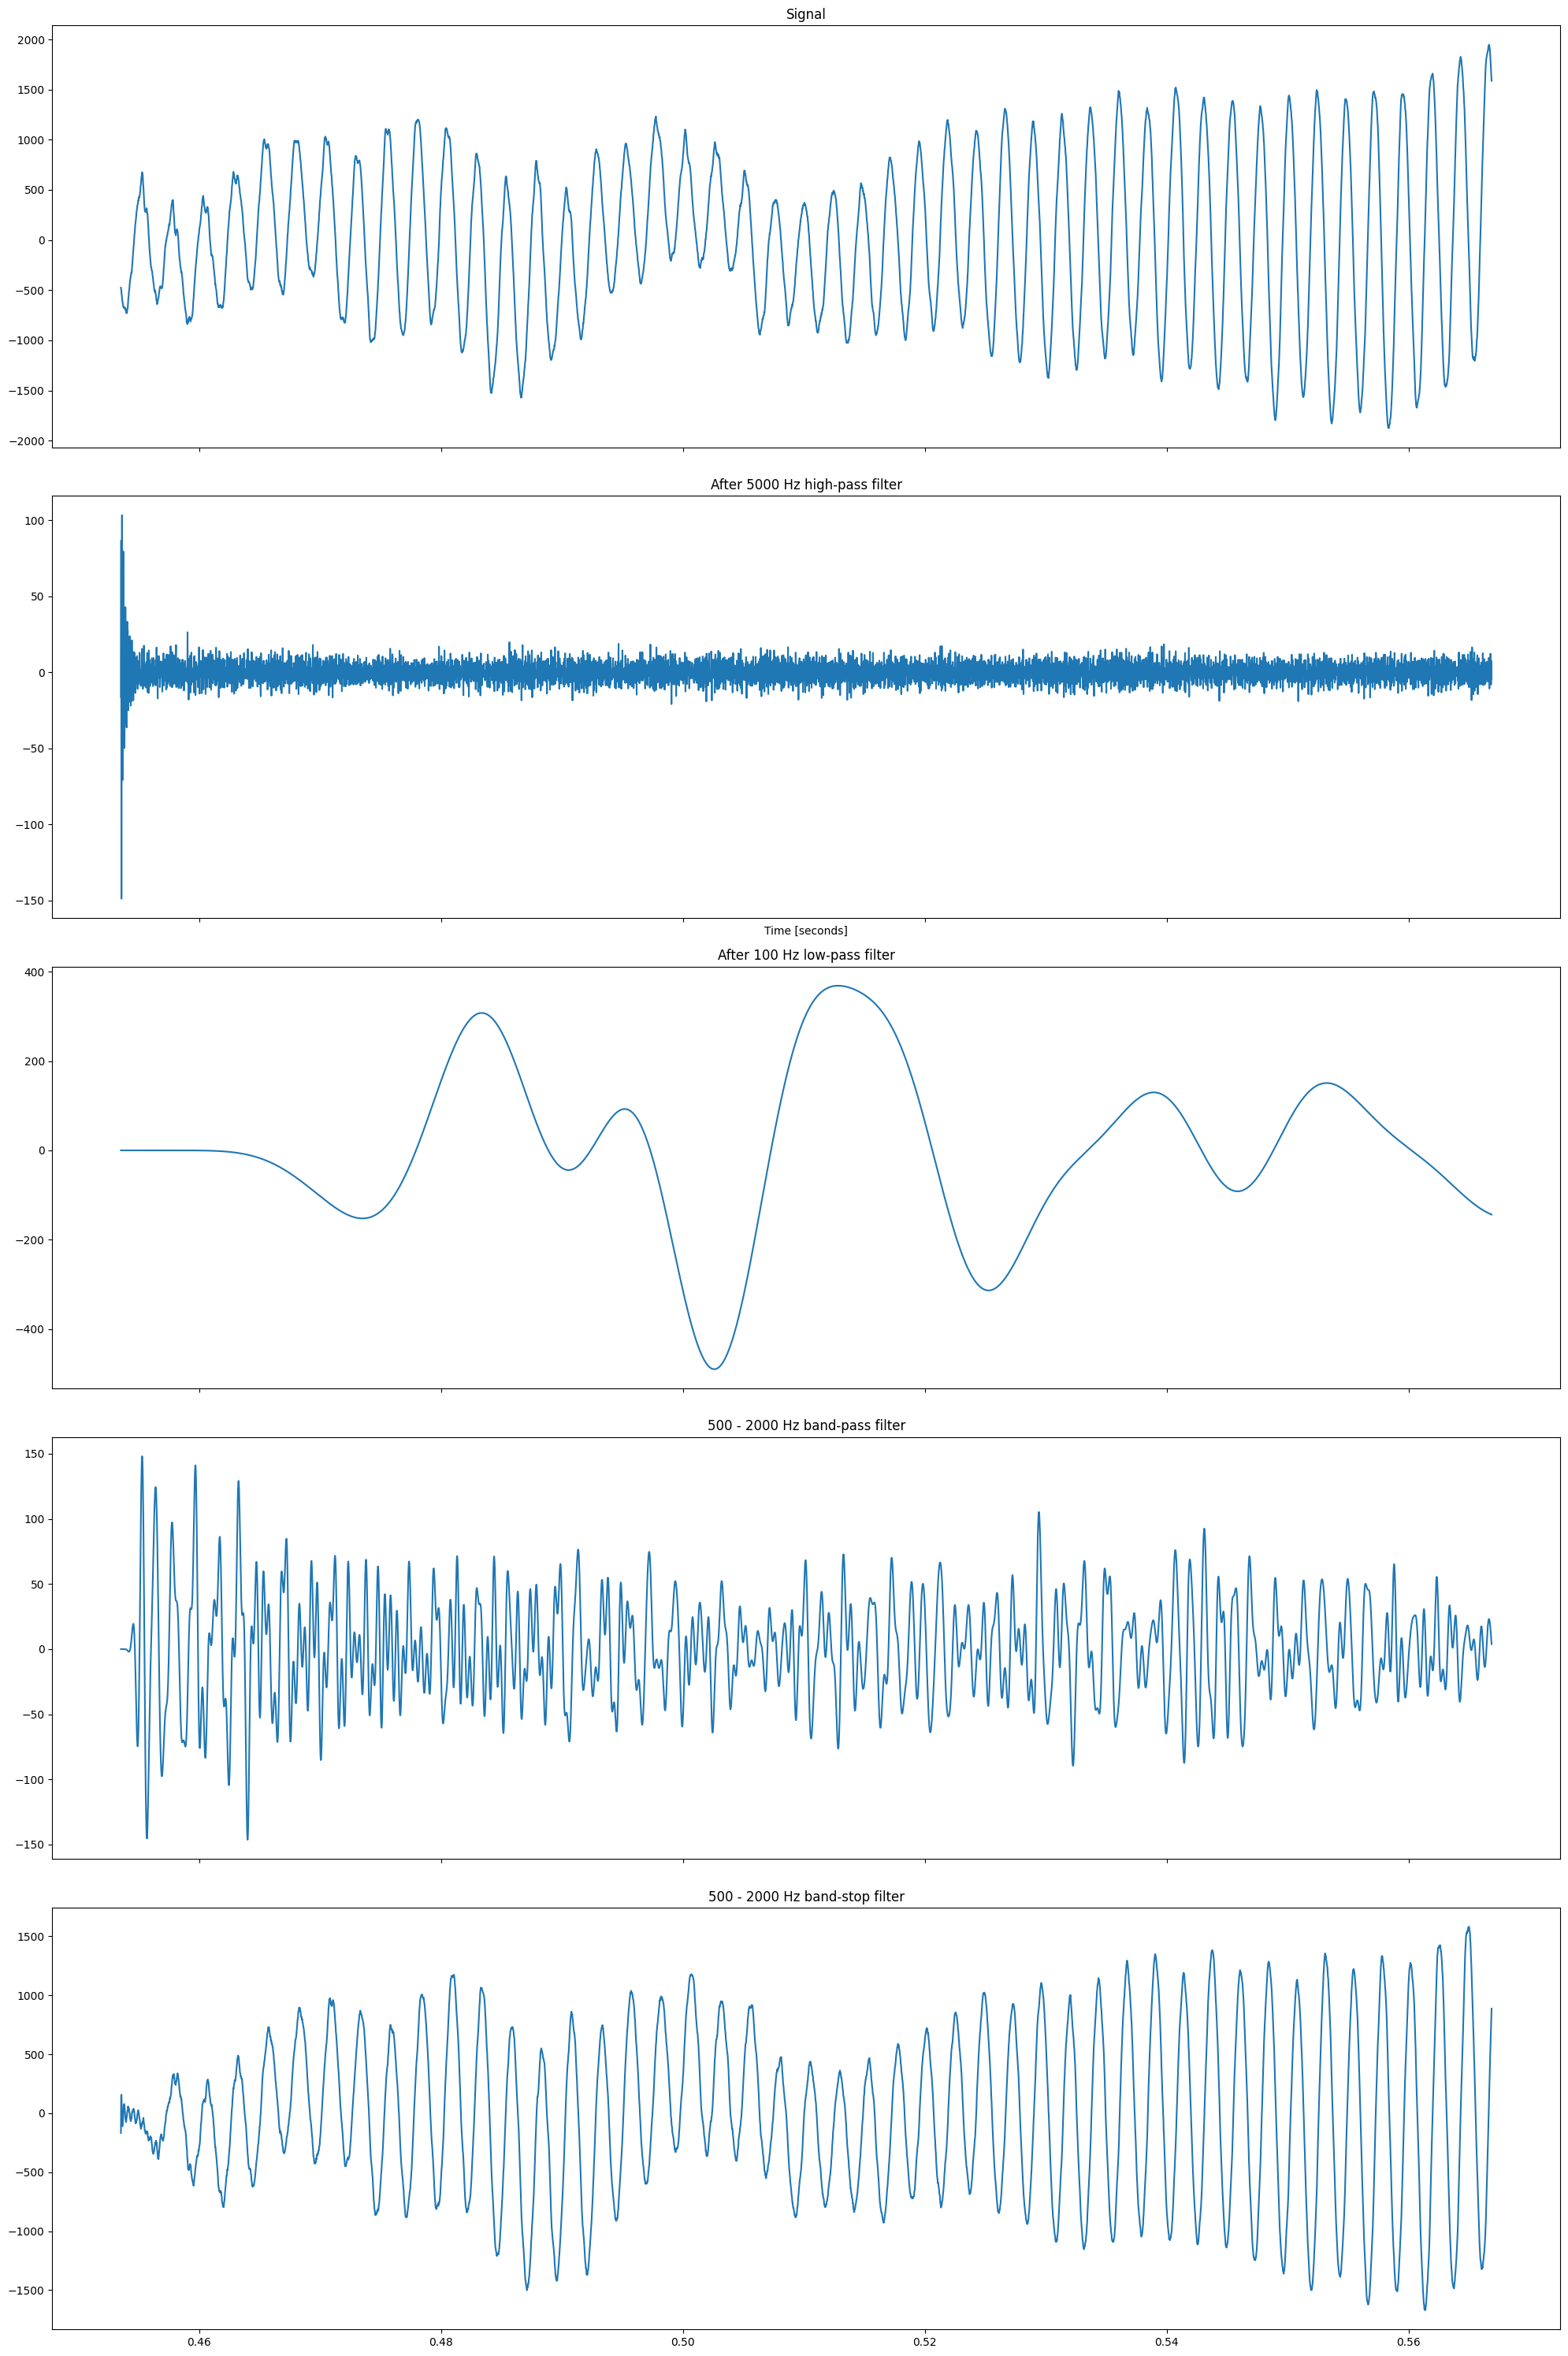

In [71]:
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=sample_rate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)

sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=sample_rate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)

sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=sample_rate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=sample_rate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)
ax1.set_title('Signal')

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

### Фильтры Баттерворта

In [72]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

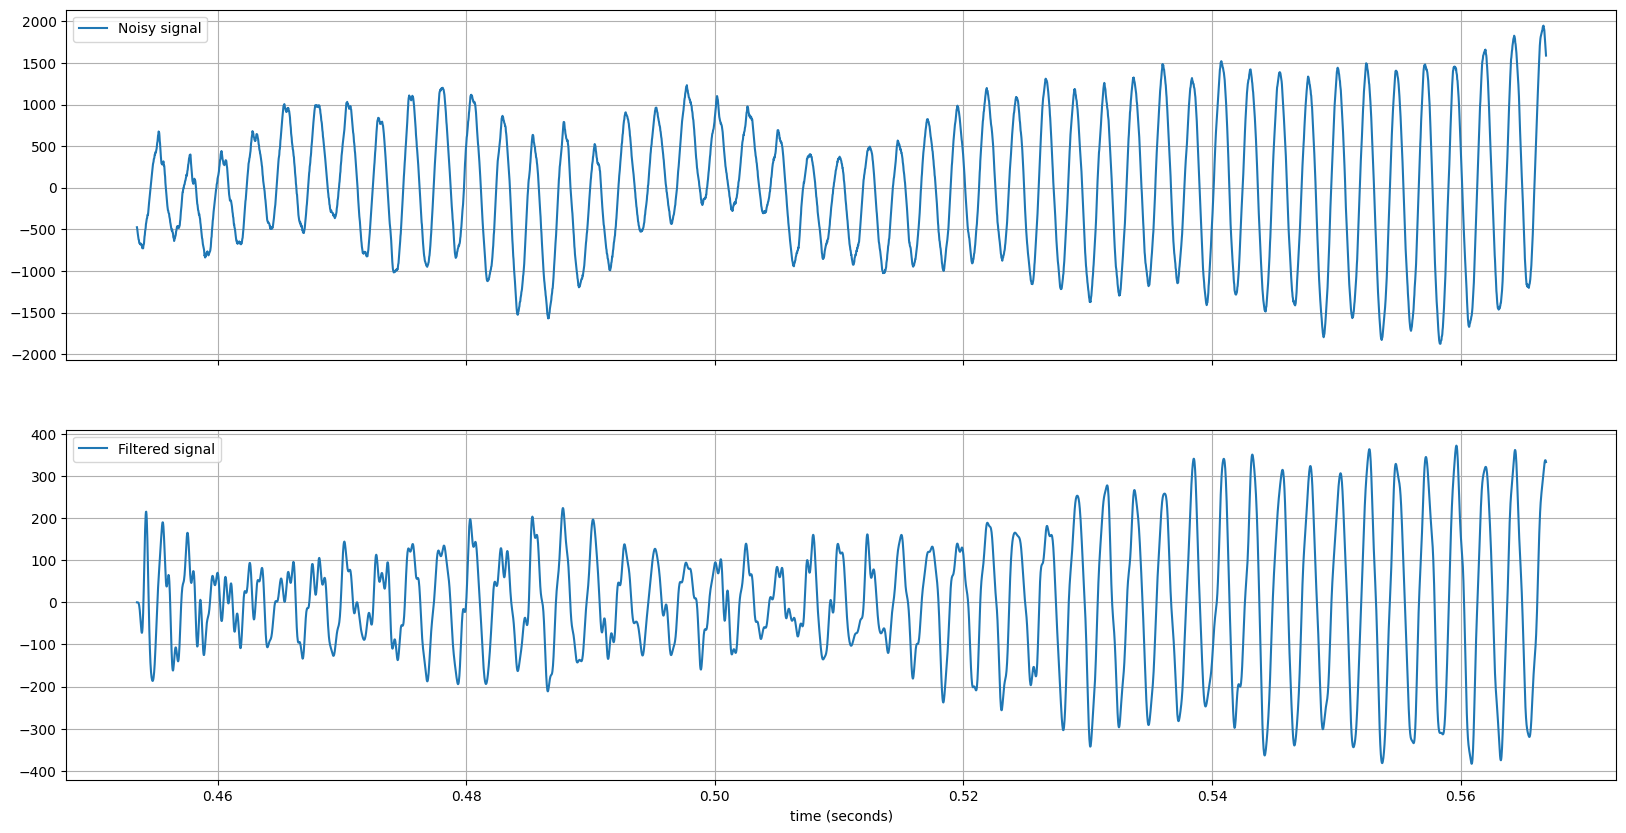

In [80]:
fs = sample_rate

lowcut = 500
highcut = 2000

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

ax1.plot(time_part, signal_part, label='Noisy signal')
ax1.grid(True)
ax1.legend()

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal')

plt.xlabel('time (seconds)')

ax2.grid(True)
ax2.legend()

plt.show()